In [6]:
# load the relevant modules for the analysis

from pl_temp_fit import Exp_data_utils

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
import json
import uuid
import numpy as np
from pl_temp_fit import config_utils
from pl_temp_fit import covariance_utils, generate_data_utils, fit_EL_utils
import emcee
import pandas as pd

os.chdir('/rds/general/user/ma11115/home/pl_temp_fit/') 
# access the right directory
#os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [27]:
import glob
from pl_temp_fit import Emcee_utils
json_files = glob.glob('fit_experimental_emcee_PL/fit_data_base/*.json')
list_model_config=[]
for id,json_file in enumerate(json_files):
    try:
        model_config, model_config_save = config_utils.load_model_config(json_file.split('/')[-1].replace('.json',''), database_folder = "fit_experimental_emcee_PL/fit_data_base")
    except Exception as e:
        print(e)
        continue
    if os.path.exists(model_config_save['save_folder']+'/sampler.h5'):      
        filename = model_config_save['save_folder'] + "/sampler.h5"
        try: 
            reader = Emcee_utils.hDFBackend_2(filename, name="multi_core")
            distribution = reader.get_chain(flat=True)
        except:
            reader = Emcee_utils.hDFBackend_2(filename, name="single_core")
            distribution = reader.get_chain(flat=True)
        true_parameters=list(np.mean(distribution,axis=0))
        model_config_save['mean'] = [f"{x:.3f}" for x in true_parameters]          
        model_config_save['num_iteration'] = reader.iteration  
        log_prob = reader.get_log_prob( flat=True)  
        model_config_save['max_log_prob'] = np.max(log_prob)
        list_model_config.append(model_config_save)

df_all = pd.DataFrame(list_model_config)
df_all.sort_values(by='date',ascending=False,inplace=True)   
df_all

,Temp_std_err,hws_std_err,relative_intensity_std_error_PL,relative_intensity_std_error_EL,sigma,save_folder,csv_name_PL,csv_name_EL,date,test_id,...,params_to_fit_init,min_bounds,max_bounds,num_iteration_max_likelihood,coeff_spread,nsteps,num_coords,mean,num_iteration,max_log_prob
4,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_PL/fit_data//2024_06_05...,experiemental_data/2023-12-12-Lowtemp-PL/IEICO...,,2024_06_05,d1a554cd-39d3-4e7e-8efc-cdf65c14cba3,...,"{'EX': {'E': 1.4, 'sigma': 0.001, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L...",5,0.5,10000,32,"[1.404, 0.002, 0.075, 0.108, 0.157]",10,-871.723462
1,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_PL/fit_data//2024_06_04...,experiemental_data/2023-12-12-Lowtemp-PL/IEICO...,,2024_06_04,7ec32554-4e8e-4830-a15d-203c341d6fd2,...,"{'EX': {'E': 1.37, 'sigma': 0.001, 'Li': 0.078...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L...",5,0.5,10000,32,"[1.398, 0.017, 0.078, 0.048, 0.130]",10020,-328.711434
2,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_PL/fit_data//2024_03_14...,experiemental_data/2023-12-12-Lowtemp-PL/IEICO...,,2024_03_14,585f3f01-a5cd-4f4e-ac4c-b1c6b5dee47b,...,"{'EX': {'E': 1.37, 'sigma': 0.001, 'Li': 0.078...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L...",5,0.5,10000,32,"[1.375, 0.001, 0.071, 0.111, 0.160]",5,-1446.023664
0,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_PL/fit_data//2024_03_12...,experiemental_data/2023-12-12-Lowtemp-PL/IEICO...,,2024_03_12,7db5f65e-55ab-4647-b543-24dc848335f2,...,"{'EX': {'E': 1.37, 'sigma': 0.001, 'LI': 0.078...","{'EX': {'E': 1.3, 'sigma': 0.001, 'LI': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'LI': 0.2, 'L...",5,0.5,10000,32,"[1.443, 0.015, 0.090, 0.118, 0.153]",200,-1663.156806
3,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_EL/2024_03_12/IEICO/387...,experiemental_data/2023-12-12-Lowtemp-PL/IEICO...,,2024_03_12,387d79f3-af40-47f2-99f4-4f9c2a5622ec,...,"{'EX': {'E': 1.37, 'sigma': 0.001, 'LI': 0.078...","{'EX': {'E': 1.3, 'sigma': 0.001, 'LI': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'LI': 0.2, 'L...",5,0.5,10000,32,"[1.374, 0.001, 0.075, 0.110, 0.157]",5,-1999.330156
5,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_EL/2024_03_12/IEICO/aa7...,experiemental_data/2023-12-12-Lowtemp-PL/IEICO...,,2024_03_12,aa76848d-7cb5-4f8e-8652-50330f2965be,...,"{'EX': {'E': 1.37, 'sigma': 0.001, 'LI': 0.078...","{'EX': {'E': 1.3, 'sigma': 0.001, 'LI': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'LI': 0.2, 'L...",5,0.5,10000,32,"[1.455, 0.017, 0.109, 0.112, 0.145]",601,-1690.548519
6,10,0.005,0.05,0.001,0.001,fit_experimental_emcee_PL/fit_data//2024_03_12...,experiemental_data/2023-12-12-Lowtemp-PL/IEICO...,,2024_03_12,4d29392b-edcd-4c8c-8320-2644e82a83c0,...,"{'EX': {'E': 1.37, 'sigma': 0.001, 'LI': 0.078...","{'EX': {'E': 1.3, 'sigma': 0.001, 'LI': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'LI': 0.2, 'L...",5,0.5,10000,32,"[1.368, 0.001, 0.083, 0.112, 0.158]",5,-1977.239713


In [29]:
index_analyse = 1
test_id = df_all['test_id'].values[index_analyse]
model_config, model_config_save = config_utils.load_model_config(test_id, database_folder = "fit_experimental_emcee_PL/fit_data_base/")
filename = model_config_save['save_folder'] + "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)  

number of iterations 10020


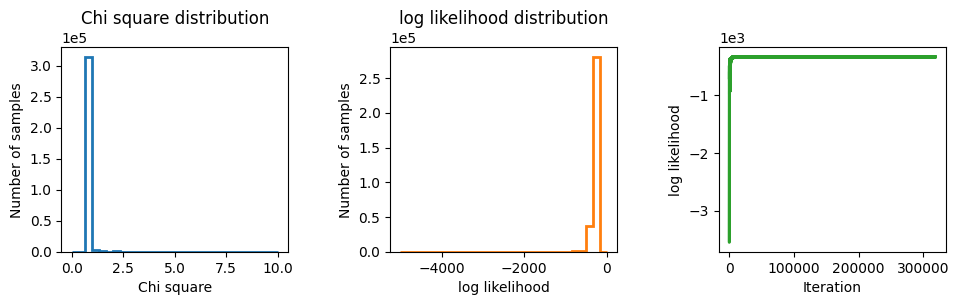

In [30]:
from pl_temp_fit import plot_utils
plot_utils.plot_fit_statistics(reader,range_log_prior = (-5000,0),discard=50,range_chi_square = (0,10))

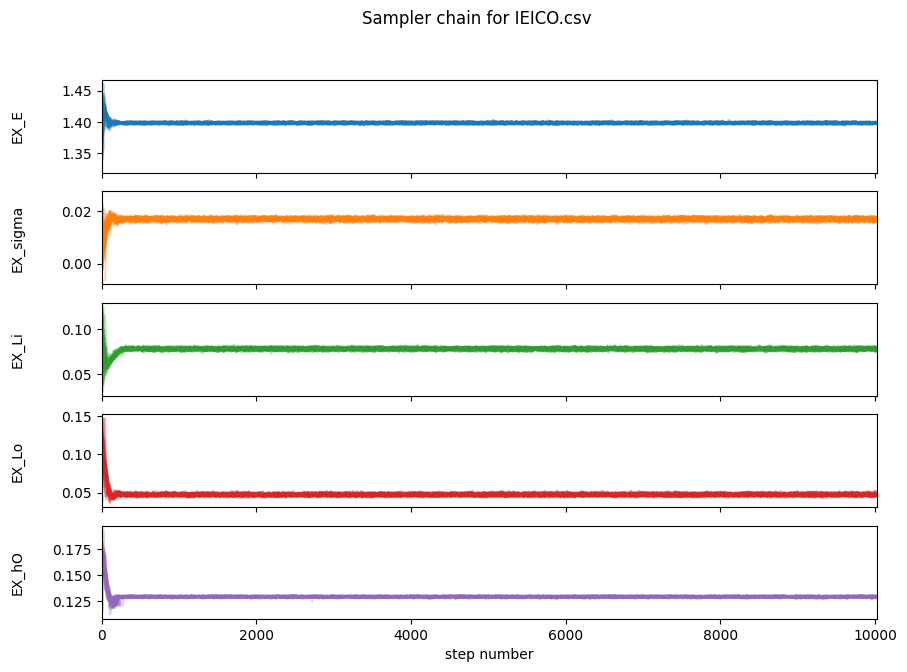

In [31]:
plot_utils.plot_chains(reader,model_config_save,discard=1)

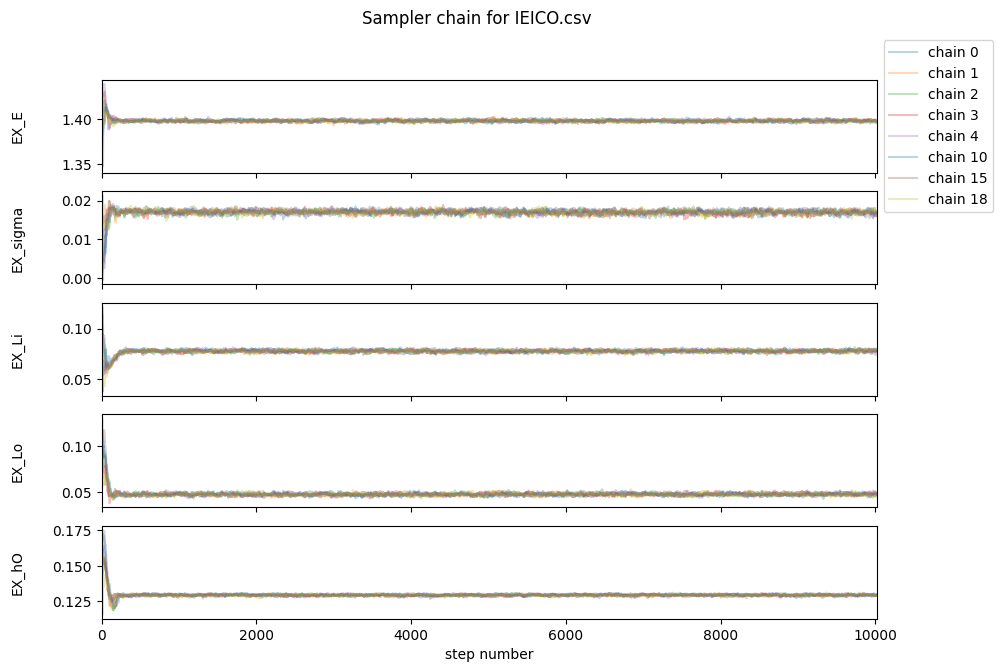

In [32]:
plot_utils.plot_diff_chains(reader,model_config_save,discard=2,chains_list = [0,1,2,3,4,10,15,18])

shape of mean value plot is (86, 8)


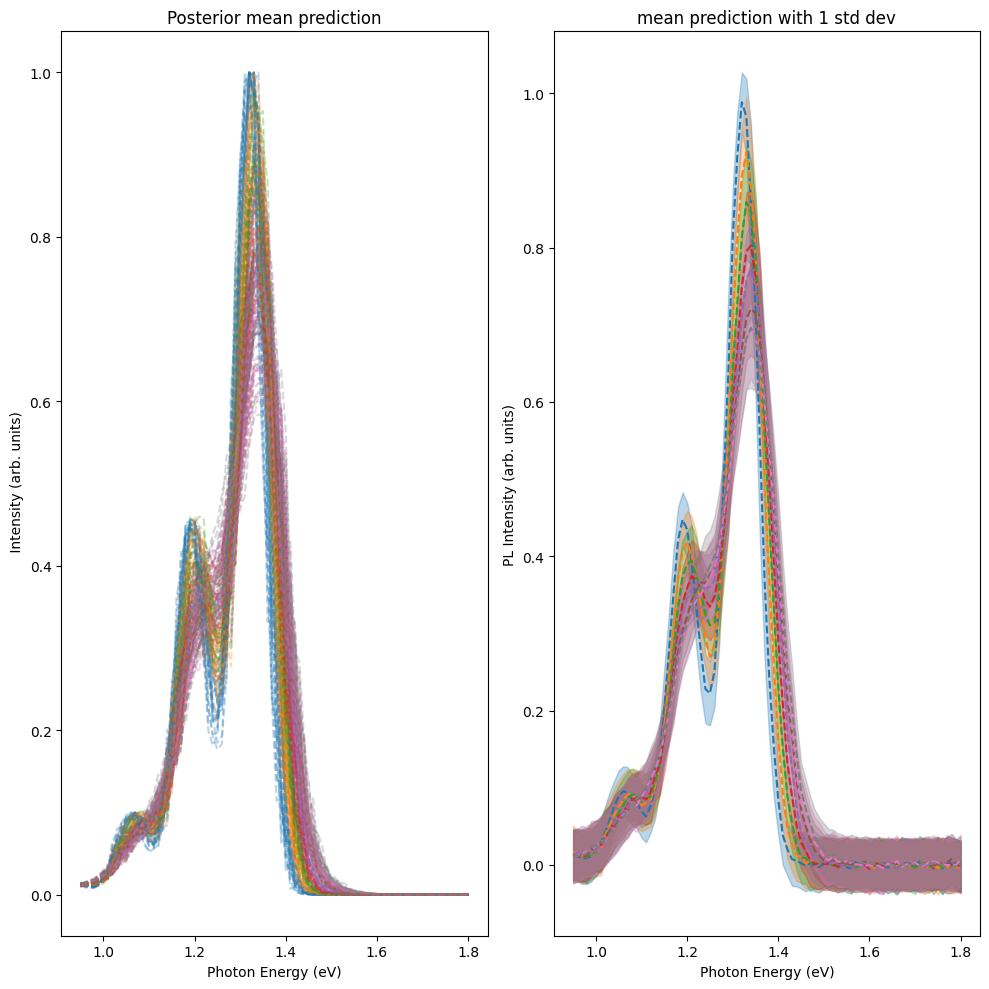

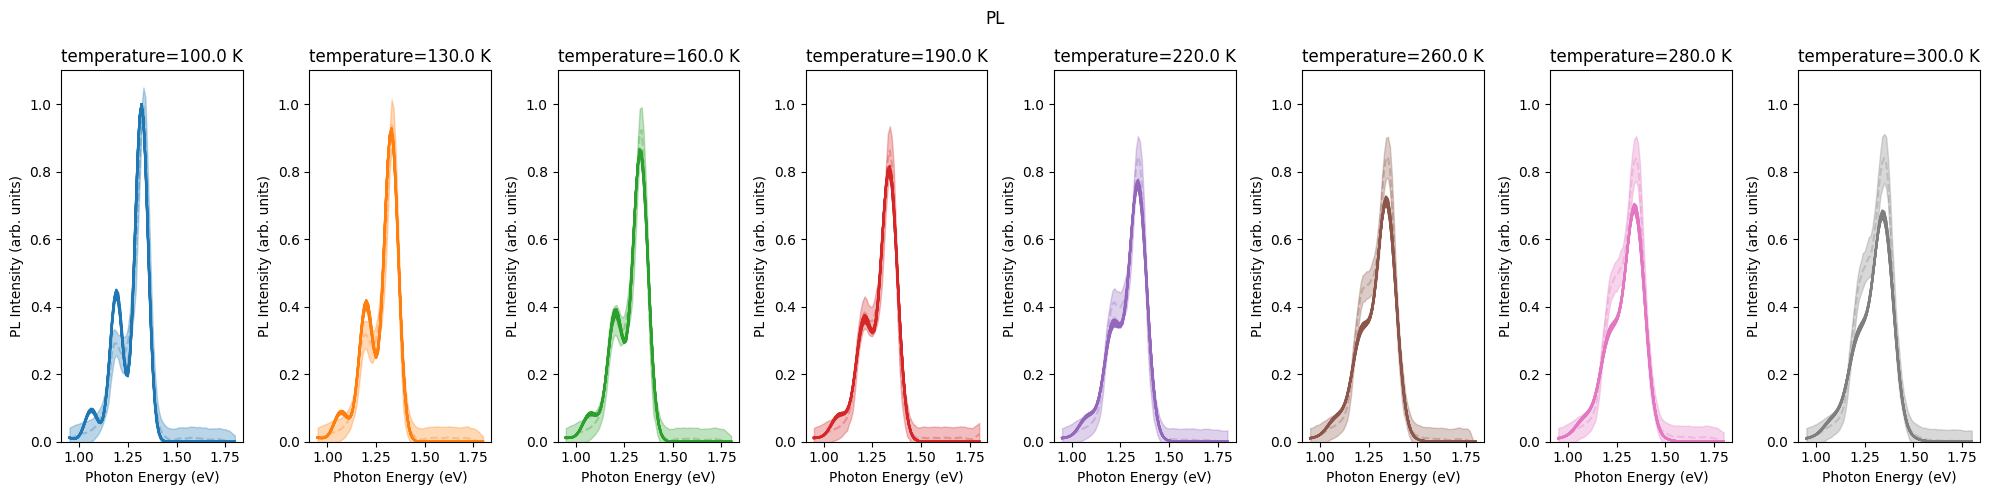

In [33]:
plot_utils.plot_fit_to_experimental_data(model_config_save,model_config,reader,discard=10)

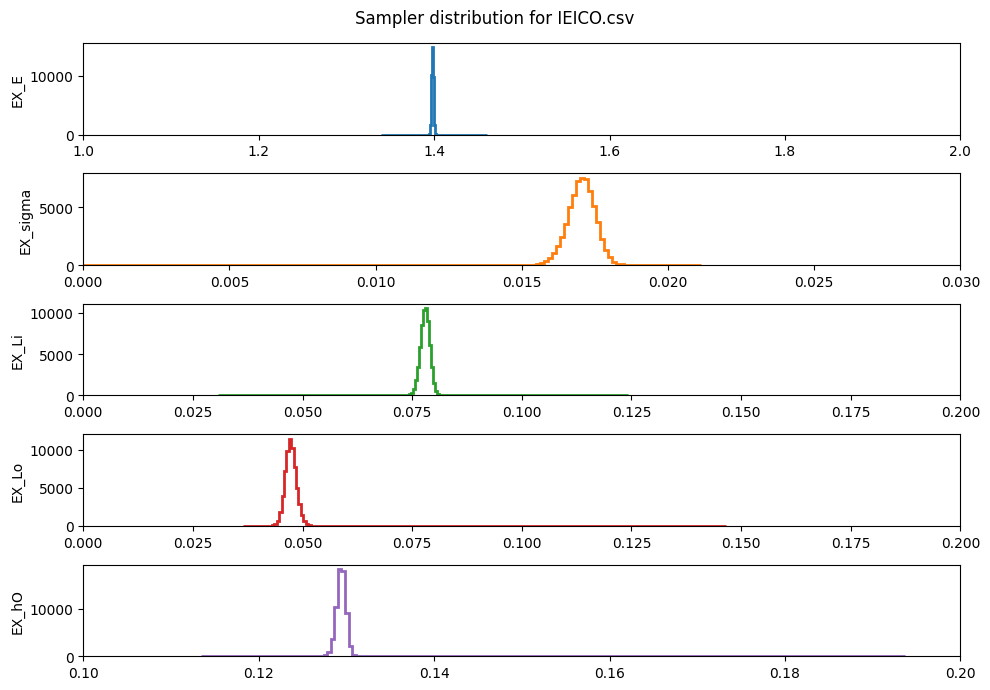

In [34]:
plot_utils.plot_distribution(reader,model_config_save,discard=10)

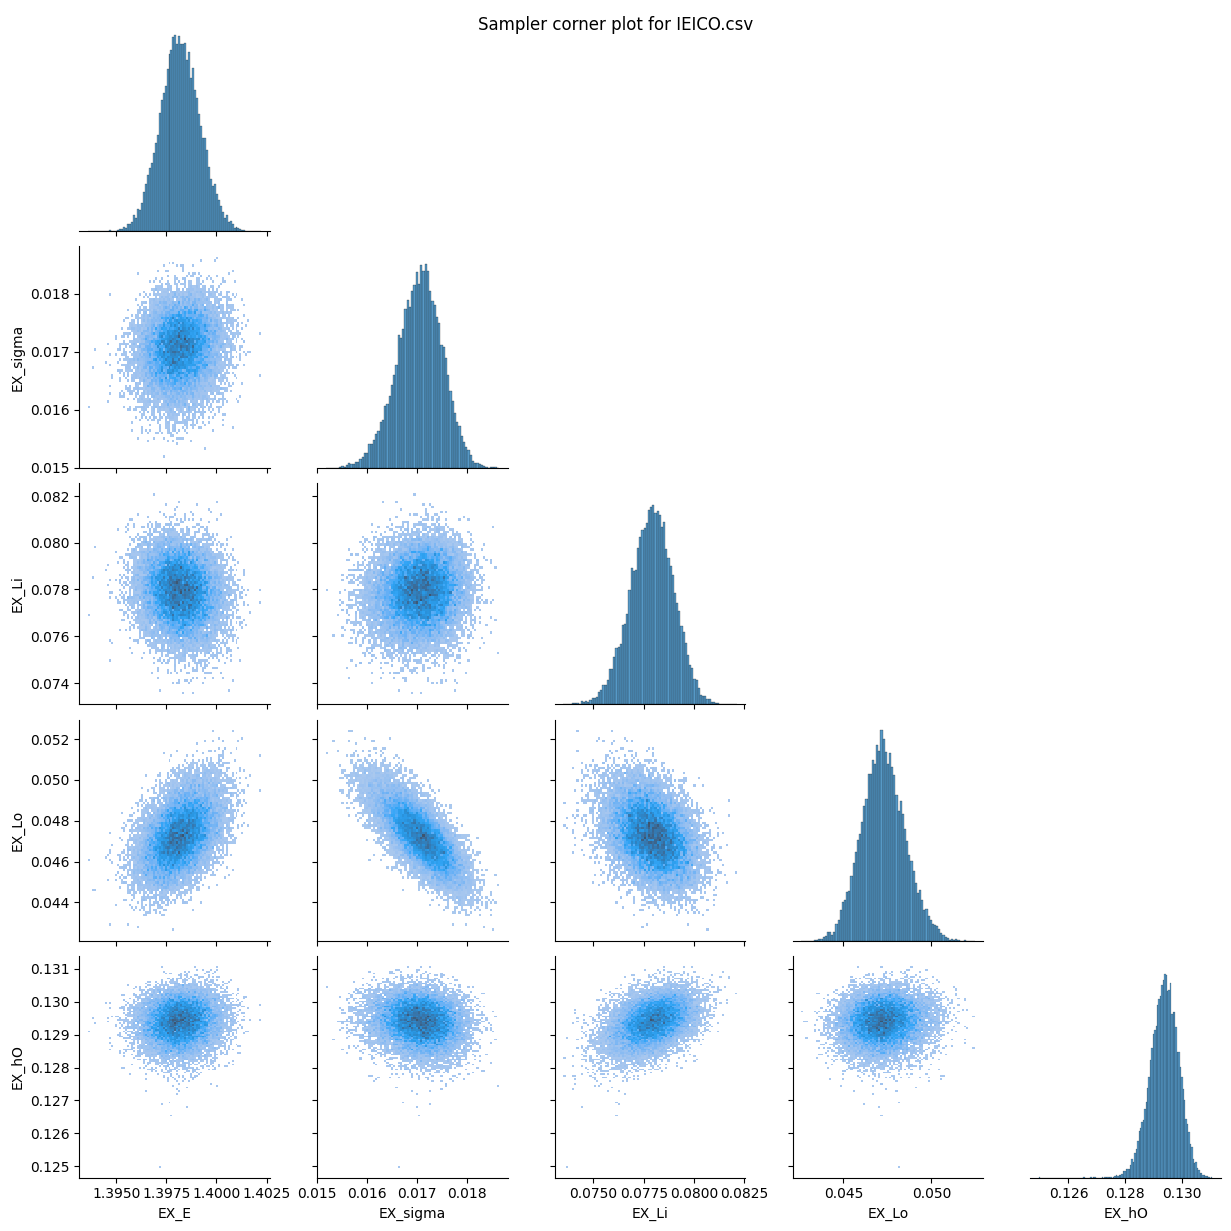

In [35]:
plot_utils.plot_corner(reader,model_config_save,discard=1000)

number of iterations 10020


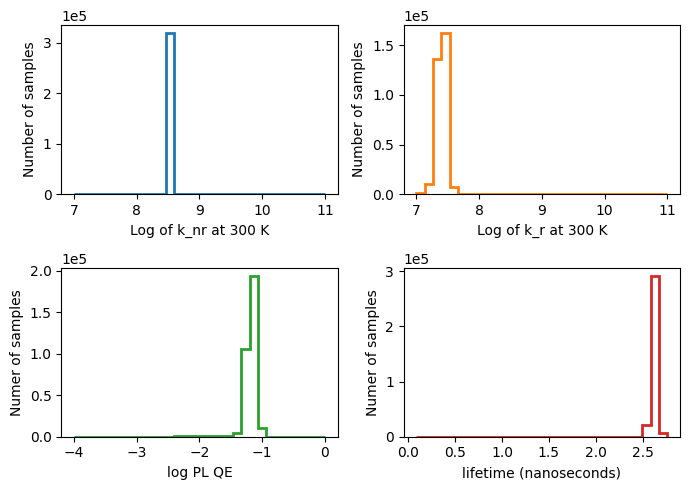

In [36]:
plot_utils.plot_lifetime(reader, discard=50)